# HW3
## Image Captioning with Conditioned LSTM Generators



Student names: Akhila Thota, Revanth Kurmeti, Jithin Krishna Kongara, Meghana Katraju, Sri Samrajya Vybhav Mallappa

Student IDs: 1002067862, 1002068038, 1002079491, 1002088571, 1002072400

Follow the instructions in this notebook step-by step. Much of the code is provided, but some sections are marked with **TODO**. 

Specifically, you will build the following components: 

* Create matrices of image representations using an off-the-shelf image encoder.
* Read and preprocess the image captions. 
* Write a generator function that returns one training instance (input/output sequence pair) at a time. 
* Train an LSTM language generator on the caption data.
* Write a decoder function for the language generator. 
* Add the image input to write an LSTM caption generator. 
* Beam search to refine output captions.

Each group please submit one copy of this notebook only, including all outputs. 

Reference:
https://medium.com/@raman.shinde15/image-captioning-with-flickr8k-dataset-bleu-4bcba0b52926#:~:text=Captions%20are%20read%20from%20Flickr8k.token.txt%20file%20and%20stored,format%20%E2%80%9Cstartseq%20%E2%80%9C%20%2B%20caption%20%2B%20%E2%80%9C%20endseq%E2%80%9D

### Getting Started 

First, run the following commands to make sure you have all required packages. 

In [ ]:
# tested with python 3.6
import os
from collections import defaultdict
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

from keras import Sequential, Model
from keras.layers import Embedding, LSTM, Dense, Input, Bidirectional, RepeatVector, Concatenate, Activation
from keras.activations import softmax
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.applications.inception_v3 import InceptionV3

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

import tensorflow as tf

# from google.colab import drive

### Access to the flickr8k data

We will use the flickr8k data set, described here in more detail: 

> M. Hodosh, P. Young and J. Hockenmaier (2013) "Framing Image Description as a Ranking Task: Data, Models and Evaluation Metrics", Journal of Artificial Intelligence Research, Volume 47, pages 853-899 http://www.jair.org/papers/paper3994.html

Dataset: https://www.kaggle.com/datasets/adityajn105/flickr8k

You need to download the dataset and then upload it again to your own drive. Please assign the name you choose for this folder to the variable `my_data_dir` in the next cell.


In [ ]:
#this is where you put the name of your data folder.
#Please make sure it's correct because it'll be used in many places later.
my_data_dir="flicker"

### Mounting your GDrive so you can access the files from Colab (optional)

In [ ]:
#running this command will generate a message that will ask you to click on a link where you'll obtain your GDrive auth code.
#copy paste that code in the text box that will appear below
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Please look at the 'Files' tab on the left side and make sure you can see the 'hw5_data' folder that you have in your GDrive.

In [ ]:
%cd /content/gdrive/MyDrive/flicker

/content/gdrive/MyDrive/flicker


## Part I: Understand the data (10 pts)

> Indented block



Read the caption file:

In [ ]:
df = pd.read_csv(f'captions.txt')
print(df.shape)
df.head()

(40455, 2)


,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


Train, test split:

In [ ]:
images_list = sorted([*set(df['image'].tolist())])
len(images_list)

8091

In [ ]:
images_list[6472]

'3601569729_bf4bf82768.jpg'

In [ ]:
# TODO: train, test split: 0.8: 0.2. ##splitting df using the image name to sorted captions into new df's  (training ,  testing) ,,, note :- captions are in sorted order 
train_df = df[df['image']<'3601569729_bf4bf82768']
test_df = df[df['image']>='3601569729_bf4bf82768']
train_df.shape,test_df.shape


((32360, 2), (8095, 2))

In [ ]:
train_df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [ ]:
train_list= sorted([*set(list(train_df["image"].values))])
test_list= sorted([*set(list(test_df["image"].values))])

In [ ]:
len(train_list),len(test_list)

(6472, 1619)

Each entry is an image filename.

Check an example:

In [ ]:
example_file = train_df.iloc[9]['image']
cap = train_df.iloc[9]['caption']
image = Image.open(os.path.join('Images', example_file))
print(image.size)
print(cap)

(500, 375)
Two dogs on pavement moving toward each other .


If you can't see the image, try

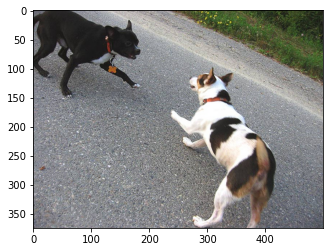

In [ ]:
plt.imshow(image)

In [ ]:
def load_image_list(filename):
  with open(filename,'r') as image_list_f:
    return [line.strip() for line in image_list_f]

## Part II: Image encoder (10 pts)
We are going to use an off-the-shelf pre-trained image encoder, the Inception V3 network. The model is a version of a convolution neural network for object detection. Here is more detail about this model (not required for this project): 

> Szegedy, C., Vanhoucke, V., Ioffe, S., Shlens, J., & Wojna, Z. (2016). Rethinking the inception architecture for computer vision. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 2818-2826).
> https://www.cv-foundation.org/openaccess/content_cvpr_2016/html/Szegedy_Rethinking_the_Inception_CVPR_2016_paper.html

The model requires that input images are presented as 299x299 pixels, with 3 color channels (RGB). The individual RGB values need to range between 0 and 1.0. The flickr images don't fit. 

In [ ]:
np.asarray(image).shape

(375, 500, 3)

The values range from 0 to 255. 

In [ ]:
np.asarray(image)

array([[[102, 103, 108],
        [ 95,  96, 101],
        [ 99, 100, 105],
        ...,
        [ 29,  29,  21],
        [ 31,  28,  23],
        [ 30,  25,  22]],

       [[108, 109, 114],
        [100, 101, 106],
        [ 94,  95, 100],
        ...,
        [ 37,  37,  29],
        [ 37,  34,  29],
        [ 33,  28,  25]],

       [[112, 112, 120],
        [118, 118, 126],
        [100, 100, 108],
        ...,
        [ 40,  40,  32],
        [ 37,  34,  29],
        [ 34,  31,  26]],

       ...,

       [[103, 101, 114],
        [104,  98, 110],
        [122, 114, 127],
        ...,
        [ 83,  88,  94],
        [ 76,  83,  89],
        [ 72,  79,  85]],

       [[111, 114, 121],
        [ 91,  88,  97],
        [ 85,  78,  86],
        ...,
        [ 95, 100, 106],
        [ 79,  84,  90],
        [ 79,  84,  90]],

       [[ 93,  96, 101],
        [ 69,  66,  73],
        [111, 101, 109],
        ...,
        [ 88,  91,  98],
        [ 82,  85,  92],
        [ 94,  99, 105]]

We can use PIL to resize the image and then divide every value by 255. 

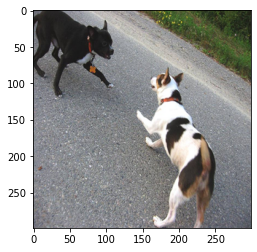

In [ ]:
new_image = np.asarray(image.resize((299,299))) / 255.0
plt.imshow(new_image)

In [ ]:
new_image.shape

(299, 299, 3)

Let's put this all in a function for convenience. 

In [ ]:
def read_image(image_name):
    image = Image.open(os.path.join('Images', image_name))
    return np.asarray(image.resize((299,299))) / 255.0                     

Next, we load the pre-trained Inception model. 

In [ ]:
img_model = InceptionV3(weights='imagenet') # This will download the weight files for you and might take a while.

96112376/96112376 [==============================] - 1s 0us/step


In [ ]:
img_model.summary() # this is quite a complex model. 

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

This is a prediction model,so the output is typically a softmax-activated vector representing 1000 possible object types. Because we are interested in an encoded representation of the image we are just going to use the second-to-last layer as a source of image encodings. Each image will be encoded as a vector of size 2048. 

We will use the following hack: hook up the input into a new Keras model and use the penultimate layer of the existing model as output.

In [ ]:
new_input = img_model.input
new_output = img_model.layers[-2].output
img_encoder = Model(new_input, new_output) # This is the final Keras image encoder model we will use.

Let's try the encoder. 

In [ ]:
encoded_image = img_encoder.predict(np.array([new_image]))

1/1 [==============================] - 10s 10s/step


In [ ]:
encoded_image.shape

(1, 2048)

**TODO:** We will need to create encodings for all images and store them in one big matrix (one for each dataset, train, test).
We can then save the matrices so that we never have to touch the bulky image data again. 

To save memory (but slow the process down a little bit) we will read in the images lazily using a generator. We will encounter generators again later when we train the LSTM. If you are unfamiliar with generators, take a look at this page: https://wiki.python.org/moin/Generators

Write the following generator function, which should return one image at a time. 
`img_list` is a list of image file names (i.e. the train, dev, or test set). The return value should be a numpy array of shape (1,299,299,3).

Now we can encode all images (this takes a few minutes).

In [ ]:


def img_generator(img_list):
  for z in img_list:
    img_list_length = len(img_list)
    _K = z[img_list_length:]
    if _K in 'Images':
      img = read_image(z)
      image_id = np.expand_dims(img, axis=0) #adding one more dimension as we need array of shape (1,299,299,3)
      yield image_id # shape: (1, 299, 299, 3)
 


In [ ]:
enc_train = img_encoder.predict(img_generator(train_list), steps=len(train_list), verbose=1)

6472/6472 [==============================] - 1384s 214ms/step


In [ ]:

enc_train.shape

(6472, 2048)

In [ ]:

enc_test = img_encoder.predict(img_generator(test_list), steps=len(test_list), verbose=1)

1619/1619 [==============================] - 350s 216ms/step


It's a good idea to save the resulting matrices, so we do not have to run the encoder again. 

In [ ]:

np.save(f"encoded_images_train.npy", enc_train)
np.save(f"encoded_images_test.npy", enc_test)


## Part III Text (Caption) Data Preparation (10 pts)

Next, we need to load the image captions and generate training data for the generator model.

### Reading image descriptions

**TODO**: Write the following function that reads the image descriptions from the file `filename` and returns a dictionary in the following format. Take a look at the file `Flickr8k.token.txt` for the format of the input file. Data from https://github.com/text-machine-lab/MUTT/tree/master/data/flickr

The keys of the dictionary should be image filenames. Each value should be a list of 5 captions. Each caption should be a list of tokens.  

The captions in the file are already tokenized, so you can just split them at white spaces. You should convert each token to lower case. You should then pad each caption with a START token on the left and an END token on the right. 

In [ ]:
from collections import defaultdict

def read_image_descriptions(filename):    
    image_descriptions = defaultdict(list)
    # TODO: here
    list_of_captions = []
    for line in open(filename,'r'):
      list_of_captions.append(line.strip())
    
      #splitting captions
    for k in list_of_captions[:-1]:
      img, k = k.split('\t')
      k = k.lower().split()                      #making it lowercase
      _des = '<START> ' + ' '.join(k) + ' <END>' #adding <START> and <END> for every sublist 
      _des = _des.split()
      if img[:-2] in image_descriptions:
        image_descriptions[img[:-2]].append(_des)
      else:
        image_descriptions[img[:-2]] = [_des]
    return image_descriptions


In [ ]:
if 'Flickr8k.token.txt' not in os.listdir():
  !wget https://raw.githubusercontent.com/text-machine-lab/MUTT/master/data/flickr/Flickr8k.token.txt

--2023-03-19 07:21:58--  https://raw.githubusercontent.com/text-machine-lab/MUTT/master/data/flickr/Flickr8k.token.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3395237 (3.2M) [text/plain]
Saving to: ‘Flickr8k.token.txt’

Flickr8k.token.txt  100%[===================>]   3.24M  --.-KB/s    in 0.1s    

2023-03-19 07:21:58 (25.9 MB/s) - ‘Flickr8k.token.txt’ saved [3395237/3395237]



In [ ]:
# Populating description dictionary using the above method
descriptions = read_image_descriptions(f"Flickr8k.token.txt")

In [ ]:
len(descriptions)

8092

In [ ]:
print(descriptions[train_list[0]])

[['<START>', 'a', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing', 'up', 'a', 'set', 'of', 'stairs', 'in', 'an', 'entry', 'way', '.', '<END>'], ['<START>', 'a', 'girl', 'going', 'into', 'a', 'wooden', 'building', '.', '<END>'], ['<START>', 'a', 'little', 'girl', 'climbing', 'into', 'a', 'wooden', 'playhouse', '.', '<END>'], ['<START>', 'a', 'little', 'girl', 'climbing', 'the', 'stairs', 'to', 'her', 'playhouse', '.', '<END>'], ['<START>', 'a', 'little', 'girl', 'in', 'a', 'pink', 'dress', 'going', 'into', 'a', 'wooden', 'cabin', '.', '<END>']]


Running the previous cell should print similar to this:     
`[['<START>', 'a', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing', 'up', 'a', 'set', 'of', 'stairs', 'in', 'an', 'entry', 'way', '.', '<END>'], ['<START>', 'a', 'girl', 'going', 'into', 'a', 'wooden', 'building', '.', '<END>'], ['<START>', 'a', 'little', 'girl', 'climbing', 'into', 'a', 'wooden', 'playhouse', '.', '<END>'], ['<START>', 'a', 'little', 'girl', 'climbing', 'the', 'stairs', 'to', 'her', 'playhouse', '.', '<END>'], ['<START>', 'a', 'little', 'girl', 'in', 'a', 'pink', 'dress', 'going', 'into', 'a', 'wooden', 'cabin', '.', '<END>']]
`    

### Creating Word Indices

Next, we need to create a lookup table from the **training** data mapping words to integer indices, so we can encode input 
and output sequences using numeric representations. **TODO** create the dictionaries id_to_word and word_to_id, which should map tokens to numeric ids and numeric ids to tokens.  
Hint: Create a set of tokens in the training data first, then convert the set into a list and sort it. This way if you run the code multiple times, you will always get the same dictionaries. 

In [ ]:
# TODO: 
# Creating the unique words list, using the set and list sort method

training_descriptions = {} 
for z in train_list:
  for _k, _v in descriptions.items():
    if z == _k:
      training_descriptions[_k] = _v

    

In [ ]:
#train_list[0:5]

In [ ]:
#dict(list(training_descriptions.items())[:2])

In [ ]:

# TODO:

import collections
token_of_words = []
for _i in training_descriptions.values():
  for caption_of_each in _i:
    for _token in caption_of_each:
        token_of_words.append(_token)
        
token_of_words = [*set(token_of_words)]

token_of_words = sorted(token_of_words)

id_to_word = {}
word_to_id = {}
# id_to_word = #..
for _i, j_ in enumerate(token_of_words):
  id_to_word[_i+1] = j_
# word_to_id = #...
  word_to_id[j_] = _i+1

In [ ]:
word_to_id['dog'] # should print an integer

2108

In [ ]:
id_to_word[1985] # should print a token

'designs'

In [ ]:
len(word_to_id)

8112

In [ ]:
len(id_to_word)

8112

Note that we do not need an UNK word token because we are generating. The generated text will only contain tokens seen at training time.  

## Part IV Basic Decoder Model (20 pts)

For now, we will just train a model for text generation without conditioning the generator on the image input. 

There are different ways to do this and our approach will be slightly different from the generator discussed in class. 

The core idea here is that the Keras recurrent layers (including LSTM) create an "unrolled" RNN. Each time-step is represented as a different unit, but the weights for these units are shared. We are going to use the constant MAX_LEN to refer to the maximum length of a sequence, which turns out to be 40 words in this data set (including START and END).

In [ ]:
max(len(description) for image_id in train_list for description in descriptions[image_id])
vocab_size = len(word_to_id)

In class, we discussed LSTM generators as transducers that map each word in the input sequence to the next word. 
<img src="http://www.cs.columbia.edu/~bauer/4705/lstm1.png" width="480px">

Instead, we will use the model to predict one word at a time, given a partial sequence. For example, given the sequence ["START","a"], the model might predict "dog" as the most likely word. We are basically using the LSTM to encode the input sequence up to this point. 
<img src="http://www.cs.columbia.edu/~bauer/4705/lstm2.png" width="480px">


To train the model, we will convert each description into a set of input output pairs as follows. For example, consider the sequence 

`['<START>', 'a', 'black', 'dog', '.', '<END>']`

We would train the model using the following input/output pairs 

| i | input                        | output |
|---|------------------------------|--------|
| 0 |[`START`]                     | `a`    |  
| 1 |[`START`,`a`]                 | `black`|
| 2 |[`START`,`a`, `black`]        | `dog`  |
| 3 |[`START`,`a`, `black`, `dog`] | `END`  |



Here is the model in Keras Keras. Note that we are using a Bidirectional LSTM, which encodes the sequence from both directions and then predicts the output. 
Also note the `return_sequence=False` parameter, which causes the LSTM to return a single output instead of one output per state. 

$$p(x) = \Pi_1^{n}p(x_i | x_1, ..., x_{i-1}, img)$$

Note also that we use an embedding layer for the input words. The weights are shared between all units of the unrolled LSTM. We will train these embeddings with the model. 

In [ ]:
MAX_LEN = 40
EMBEDDING_DIM=300
vocab_size = len(word_to_id)

# Text input
text_input = Input(shape=(MAX_LEN,))
embedding = Embedding(vocab_size, EMBEDDING_DIM, input_length=MAX_LEN)(text_input)
x = Bidirectional(LSTM(512, return_sequences=False))(embedding)
pred = Dense(vocab_size, activation='softmax')(x)
model = Model(inputs=[text_input],outputs=pred)
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 40)]              0         
                                                                 
 embedding (Embedding)       (None, 40, 300)           2433600   
                                                                 
 bidirectional (Bidirectiona  (None, 1024)             3330048   
 l)                                                              
                                                                 
 dense (Dense)               (None, 8112)              8314800   
                                                                 
Total params: 14,078,448
Trainable params: 14,078,448
Non-trainable params: 0
_________________________________________________________________


The model input is a numpy ndarray (a tensor) of size `(batch_size, MAX_LEN)`. Each row is a vector of size MAX_LEN in which each entry is an integer representing a word (according to the `word_to_id` dictionary). If the input sequence is shorter than MAX_LEN, the remaining entries should be padded with 0. 

For each input example, the model returns a softmax activated vector (a probability distribution) over possible output words. The model output is a numpy ndarray of size `(batch_size, vocab_size)`. vocab_size is the number of vocabulary words. 

### Creating a Generator for the Training Data

**TODO**: 

We could simply create one large numpy ndarray for all the training data. Because we have a lot of training instances (each training sentence will produce up to MAX_LEN input/output pairs, one for each word), it is better to produce the training examples *lazily*, i.e. in batches using a generator (recall the image generator in part I). 

Write the function `text_training_generator` below, that takes as a paramater the batch_size and returns an `(input, output)` pair. `input` is a `(batch_size, MAX_LEN)` ndarray of partial input sequences, `output` contains the next words predicted for each partial input sequence, encoded as a `(batch_size, vocab_size)` ndarray.

Each time the next() function is called on the generator instance, it should return a new batch of the *training* data. You can use `train_list` as a list of training images. A batch may contain input/output examples extracted from different descriptions or even from different images. 

You can just refer back to the variables you have defined above, including `descriptions`, `train_list`, `vocab_size`, etc. 


Hint: To prevent issues with having to reset the generator for each epoch and to make sure the generator can always return exactly `batch_size` input/output pairs in each step, wrap your code into a `while True:` loop. This way, when you reach the end of the training data, you will just continue adding training data from the beginning into the batch. 

In [ ]:

# TODO: data generator, intended to be used in a call to model.fit_generator()

def text_training_generator(batch_size=128):
  text_input = []
  output_list = []
  _count= 0
  
    
  while True:
    for _p in train_list:
      for x in descriptions[_p]:
        for _i in range(len(x)):
          _count += 1
        
          if _count < batch_size:
            _v = np.zeros(40, dtype = int)    #setting up Input array shape

            for j in range(_i):
              _v[j] = word_to_id[x[j]]

            if _i == 0:
              continue
              
            text_input.append(_v)
            _res = np.zeros(vocab_size, dtype = int)      #setting up output array shape
            _res[word_to_id[x[j+1]]] = 1
            output_list.append(_res)
 
          else:
              yield (np.array(text_input), np.array(output_list))

            
      

### Training the Model

We will use the `fit_generator` method of the model to train the model. fit_generator needs to know how many iterator steps there are per epoch.

Because there are len(train_list) training samples with up to `MAX_LEN` words, an upper bound for the number of total training instances is `len(train_list)*MAX_LEN`. Because the generator returns these in batches, the number of steps is len(train_list) * MAX_LEN // batch_size

In [ ]:
batch_size = 128
generator = text_training_generator(batch_size)
steps = len(train_list) * MAX_LEN // batch_size 

In [ ]:
model.fit(generator, steps_per_epoch=steps, verbose=True, epochs=10)

Epoch 1/10
2022/2022 [==============================] - 90s 41ms/step - loss: 0.6637 - accuracy: 0.7882
Epoch 2/10
2022/2022 [==============================] - 86s 43ms/step - loss: 0.1687 - accuracy: 0.9153
Epoch 3/10
2022/2022 [==============================] - 85s 42ms/step - loss: 0.1683 - accuracy: 0.9153
Epoch 4/10
2022/2022 [==============================] - 85s 42ms/step - loss: 0.1681 - accuracy: 0.9153
Epoch 5/10
2022/2022 [==============================] - 85s 42ms/step - loss: 0.1680 - accuracy: 0.9153
Epoch 6/10
2022/2022 [==============================] - 86s 42ms/step - loss: 0.1680 - accuracy: 0.9153
Epoch 7/10
2022/2022 [==============================] - 86s 42ms/step - loss: 0.1679 - accuracy: 0.9153
Epoch 8/10
2022/2022 [==============================] - 85s 42ms/step - loss: 0.1679 - accuracy: 0.9153
Epoch 9/10
2022/2022 [==============================] - 86s 42ms/step - loss: 0.1679 - accuracy: 0.9153
Epoch 10/10
2022/2022 [==============================] - 85s 42m

Continue to train the model until you reach an accuracy of at least 40%. 

### Greedy Decoder

**TODO** Next, you will write a decoder. The decoder should start with the sequence `["<START>"]`, use the model to predict the most likely word, append the word to the sequence and then continue until `"<END>"` is predicted or the sequence reaches `MAX_LEN` words. 

In [ ]:
def decoder():
  output_list = ["<START>"]
      # TODO:
  for i in range(MAX_LEN - 1):
    input = np.zeros(40, dtype = int) #setting up Input array shape


    for i in range(len(output_list)):
      input[i] = word_to_id[output_list[i]]  

    input = input.reshape(1, MAX_LEN)
    _mp = model.predict([input],verbose =0)  #predicting using model
    pred = np.argmax(_mp)
    output_list.append(id_to_word[pred])

    if id_to_word[pred] == "<END>":
      return " ".join(output_list)


In [ ]:
print(decoder())

<START> a little girl climbing the stairs to her playhouse . <END>


This simple decoder will of course always predict the same sequence (and it's not necessarily a good one). 

Modify the decoder as follows. Instead of choosing the most likely word in each step, sample the next word from the distribution (i.e. the softmax activated output) returned by the model. Take a look at the [np.random.multinomial](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.multinomial.html) function to do this. 

In [ ]:
def sample_decoder():
  output_list = ["<START>"]
      # TODO:
  for i in range(MAX_LEN - 1):
    input = np.zeros(40, dtype = np.float32)  #setting up Input array shape

    for i in range(len(output_list)):
      input[i] = word_to_id[output_list[i]]

    input = input.reshape(1, MAX_LEN)
    pred = model.predict([input],verbose =0)
    pred = np.asarray(pred).astype('float64')    #predicting using model
    pred = pred.astype(float)
    pred[0] /= pred[0].sum()
    rs = np.random.multinomial(1,pred[0]) #random the next from the distribution 
    rs = list(rs).index(1)

    output_list.append(id_to_word[rs])

    if id_to_word[rs] == "<END>":
      return " ".join(output_list)

You should now be able to see some interesting output that looks a lot like flickr8k image captions -- only that the captions are generated randomly without any image input. 

In [ ]:
for i in range(10):
  print(sample_decoder())

<START> a little girl in a pink dress going into a wooden cabin . <END>
<START> a little girl climbing into a wooden playhouse . <END>
<START> a little girl climbing into a wooden playhouse . <END>
<START> a black dog and a tri-colored dog playing with each other on the road . <END>
<START> a little girl climbing into a wooden playhouse . <END>
<START> a black dog and a spotted dog are fighting <END>
<START> a black dog and a white dog with brown spots are staring at each other in the street . <END>
<START> a black dog and a tri-colored dog playing with each other on the road . <END>
<START> a little girl climbing into a wooden playhouse . <END>
<START> a little girl in a pink dress going into a wooden cabin . <END>


## Part V - Conditioning on the Image (20 pts)

We will now extend the model to condition the next word not only on the partial sequence, but also on the encoded image. 

We will project the 2048-dimensional image encoding to a 300-dimensional hidden layer. 
We then concatenate this vector with each embedded input word, before applying the LSTM.

Here is what the Keras model looks like: 

In [ ]:
MAX_LEN = 40
EMBEDDING_DIM=300
IMAGE_ENC_DIM=300

# Image input
img_input = Input(shape=(2048,))
img_enc = Dense(300, activation="relu") (img_input)
images = RepeatVector(MAX_LEN)(img_enc)

# Text input
text_input = Input(shape=(MAX_LEN,))
embedding = Embedding(vocab_size, EMBEDDING_DIM, input_length=MAX_LEN)(text_input)
x = Concatenate()([images,embedding])
y = Bidirectional(LSTM(256, return_sequences=False))(x) 
pred = Dense(vocab_size, activation='softmax')(y)
model = Model(inputs=[img_input,text_input],outputs=pred)
model.compile(loss='categorical_crossentropy', optimizer="RMSProp", metrics=['accuracy'])

model.summary()




Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 dense_1 (Dense)                (None, 300)          614700      ['input_3[0][0]']                
                                                                                                  
 input_4 (InputLayer)           [(None, 40)]         0           []                               
                                                                                                  
 repeat_vector (RepeatVector)   (None, 40, 300)      0           ['dense_1[0][0]']                
                                                                                            

The model now takes two inputs: 
    
   1. a `(batch_size, 2048)` ndarray of image encodings. 
   2. a `(batch_size, MAX_LEN)` ndarray of partial input sequences. 
    
And one output as before: a `(batch_size, vocab_size)` ndarray of predicted word distributions.   

**TODO**: Modify the training data generator to include the image with each input/output pair. 
Your generator needs to return an object of the following format: `([image_inputs, text_inputs], next_words)`. Where each element is an ndarray of the type described above.  

You need to find the image encoding that belongs to each image. You can use the fact that the index of the image in `train_list` is the same as the index in enc_train and enc_dev. 

If you have previously saved the image encodings, you can load them from disk: 

In [ ]:
enc_train = np.load("encoded_images_train.npy")
enc_test = np.load("encoded_images_test.npy")


In [ ]:
def training_generator(batch_size=2048):
  img_input=[]
  _count = 0
  text_input = []
  output_txt = []

  while True:
    for p in train_list:
      for k in descriptions[p]:
        for i in range(len(k)):
          _count += 1
        
          if _count < batch_size:
            _v = np.zeros(40, dtype = int)  #setting up Input array shape

            for j in range(i):
              _v[j] = word_to_id[k[j]]

            if i == 0:
              continue

            img_input.append(enc_train[train_list.index(p)])
            text_input.append(_v)
            result = np.zeros(vocab_size, dtype = int)  #predicting using model
            result[word_to_id[k[j+1]]] = 1
            output_txt.append(result)

          else:
              yield ([np.array(img_input),np.array(text_input)], np.array(output_txt))

You should now be able to train the model as before: 

In [ ]:
batch_size = 2048
generator = training_generator(batch_size)
steps = len(train_list) * MAX_LEN // batch_size 

In [ ]:
model.fit(generator, steps_per_epoch=steps, verbose=1, epochs=10)

Epoch 1/10
126/126 [==============================] - 42s 336ms/step - loss: 3.8238 - accuracy: 0.1175
Epoch 2/10
126/126 [==============================] - 45s 359ms/step - loss: 3.2304 - accuracy: 0.1219
Epoch 3/10
126/126 [==============================] - 45s 356ms/step - loss: 3.2130 - accuracy: 0.1214
Epoch 4/10
126/126 [==============================] - 45s 356ms/step - loss: 3.1876 - accuracy: 0.1229
Epoch 5/10
126/126 [==============================] - 45s 360ms/step - loss: 3.1741 - accuracy: 0.1248
Epoch 6/10
126/126 [==============================] - 45s 357ms/step - loss: 3.0311 - accuracy: 0.1463
Epoch 7/10
126/126 [==============================] - 45s 358ms/step - loss: 2.5612 - accuracy: 0.2101
Epoch 8/10
126/126 [==============================] - 45s 356ms/step - loss: 2.1803 - accuracy: 0.2824
Epoch 9/10
126/126 [==============================] - 45s 357ms/step - loss: 1.8408 - accuracy: 0.3720
Epoch 10/10
126/126 [==============================] - 45s 356ms/step - l

Again, continue to train the model until you hit an accuracy of about 40%. This may take a while. I strongly encourage you to experiment with cloud GPUs using the GCP voucher for the class. 

You can save your model weights to disk and continue at a later time. 

In [ ]:
model.save_weights("model.h5")

to load the model: 

In [ ]:
model.load_weights("model.h5")

dcaptions = df_txt0["caption"].iloc[keepindex].values**TODO**: Now we are ready to actually generate image captions using the trained model. Modify the simple greedy decoder you wrote for the text-only generator, so that it takes an encoded image (a vector of length 2048) as input, and returns a sequence.

In [ ]:
def image_decoder(enc_image):
  output_list = ['<START>']
    # TODO:
  len = MAX_LEN-1
  tx = output_list[0]
  co = 0
  for i in range(MAX_LEN - 1):
    input_txt = np.zeros((1,40), dtype = int)    #setting up Input array shape

    while co < len and tx != "<END>":
      input_txt[0][co] = word_to_id[tx]
      pred = model.predict([enc_image, input_txt],verbose =0)     #predicting model
      word = id_to_word[np.argmax(pred)]
      co += 1 
      if word != tx:
        input_txt[0][co] = word_to_id[word]
        output_list.append(word)
        tx = word
      
    return " ".join(output_list)   

<START> a little girl climbing a wooden playhouse . <END>


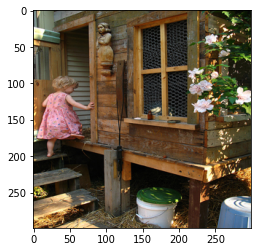

In [ ]:

idx = 0
image = np.array(enc_train[idx]).reshape(1,2048)
t = np.array(enc_train[idx]).reshape(1,2048)
plt.imshow(read_image(train_list[idx]))
print(image_decoder(image))


<START> a black dog and a dog are each other on the . <END>


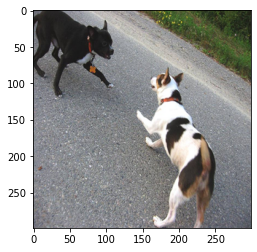

In [ ]:
# Training image test-1

idx = 1
image = np.array(enc_train[idx]).reshape(1,2048)
t = np.array(enc_train[idx]).reshape(1,2048)
plt.imshow(read_image(train_list[idx]))
print(image_decoder(image))


<START> a dog running through snow . <END>


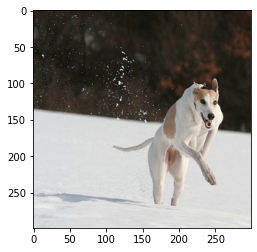

In [ ]:

idx = 10
image = np.array(enc_train[idx]).reshape(1,2048)
t = np.array(enc_train[idx]).reshape(1,2048)
plt.imshow(read_image(train_list[idx]))

print(image_decoder(image))

<START> a dog is to catch a yellow ball through . <END>


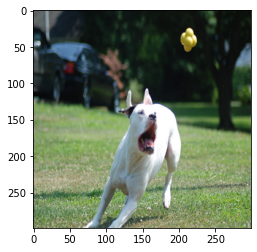

In [ ]:

idx = 14
image = np.array(enc_train[idx]).reshape(1,2048)

t = np.array(enc_train[idx]).reshape(1,2048)
plt.imshow(read_image(train_list[idx]))
print(image_decoder(image))

You should also be able to apply the model to dev images and get reasonable captions:

'<START> a dog in <END>'

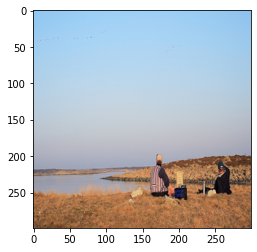

In [ ]:

# Testing test image 1
idx = 817

t = np.array(enc_test[idx]).reshape(1,2048)
plt.imshow(read_image(test_list[idx]))
image_decoder(t)

## Part VII Beam search (10 pts)

**TODO**: Use beam search algorithm to refine the output captions.

Reference: https://keras.io/api/keras_nlp/utils/beam_search/

https://keras.io/examples/nlp/text_generation_gpt/

In [ ]:
def beam_search(image, beam_index = 5, log = False):
    
    output_list = [[[word_to_id["<START>"]], 0.0]]
    
    
    while len(output_list[0][0]) < MAX_LEN:
        tp = []
        for s in output_list:
            per_cps = pad_sequences([s[0]], maxlen=MAX_LEN, padding='post').reshape((1,MAX_LEN))
            a = image
            
            _preds = model.predict([a,per_cps],verbose = 0)
            
            # Getting the top <beam_index>(n) predictions
            
            word_preds = np.argsort(_preds[0])[-beam_index:]
            
            
            # creating a new list so as to put them via the model again
            
            
            for y in word_preds:
                nxt_cp, prb = s[0][:], s[1]
                nxt_cp.append(y)
                if log:           #log functions  -  to predict
                    prb += np.log(_preds[0][y]) 
                else:
                    prb += _preds[0][y]
                tp.append([nxt_cp, prb])
                    
        output_list = tp
        
        output_list = sorted(output_list, reverse=False, key=lambda l: l[1])
        output_list = output_list[-beam_index:]
    
    output_list = output_list[-1][0]
    
    intermediate_of_caption = [id_to_word[k] for k in output_list]

    final_cptn = []
    
    
    for m in intermediate_of_caption:
        if m != '<END>':
            final_cptn.append(m)
        else:
            final_cptn.append(m)
            break
    
    
    final_cptn = ' '.join(final_cptn)
    return final_cptn


**TODO**: Randomly plot 10 images with captions from train set and test set each.

### Training Results

prediction-1
Captions generated using Greedy-Search


<START> a little girl climbing a wooden playhouse . <END> 

Captions generated using Beam-Search


<START> a little girl climbing a wooden playhouse . <END>
<START> a little girl in a wooden playhouse . <END>
<START> a little girl in a wooden playhouse . <END>
<START> a little girl in a wooden playhouse . <END>


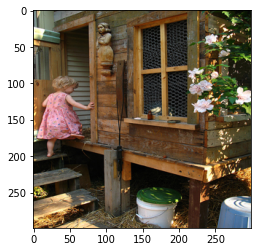

In [ ]:
idx = 0

print("prediction-1")
image = np.array(enc_train[idx]).reshape(1,2048)
plt.imshow(read_image(train_list[idx]))
print("Captions generated using Greedy-Search")
print("\n")
print(image_decoder(image),"\n")
print("Captions generated using Beam-Search")
print("\n")
print(beam_search(image, beam_index = 1, log=False))
      
print(beam_search(image, beam_index = 2, log=False))
print(beam_search(image, beam_index = 3, log=True))
print(beam_search(image, beam_index = 4, log=True))

      

prediction-2
Captions generated using Greedy-Search


<START> a group of people climbing while rock . <END> 

Captions generated using Beam-Search


<START> a group of people climbing climbing climbing while rock . <END>
<START> a group of people climbing climbing a while while . <END>
<START> a group of people climbing climbing a while while . <END>
<START> a group of people climbing climbing a while while . <END>


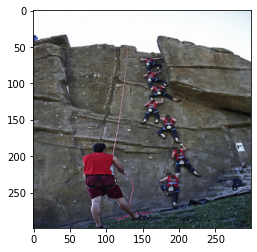

In [ ]:
idx = 12

print("prediction-2")
image = np.array(enc_train[idx]).reshape(1,2048)
plt.imshow(read_image(train_list[idx]))
print("Captions generated using Greedy-Search")
print("\n")
print(image_decoder(image),"\n")
print("Captions generated using Beam-Search")
print("\n")
print(beam_search(image, beam_index = 1, log=False))

print(beam_search(image, beam_index = 2, log=False))
print(beam_search(image, beam_index = 3, log=False))
print(beam_search(image, beam_index = 3, log=True))


prediction-3
Captions generated using Greedy-Search


<START> a black dog leaps over a log . <END> 

Captions generated using Beam-Search


<START> a black dog leaps over a log . <END>
<START> a black dog leaps over a log . <END>
<START> a black dog leaps over a log . <END>
<START> a black dog leaps over a . <END>


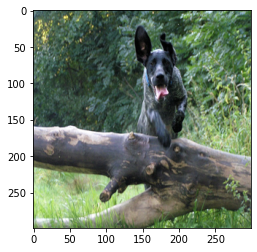

In [ ]:
idx = 9

print("prediction-3")
image = np.array(enc_train[idx]).reshape(1,2048)
plt.imshow(read_image(train_list[idx]))
print("Captions generated using Greedy-Search")
print("\n")
print(image_decoder(image),"\n")
print("Captions generated using Beam-Search")
print("\n")
print(beam_search(image, beam_index = 1, log=False))
print(beam_search(image, beam_index = 2, log=True))
print(beam_search(image, beam_index = 3, log=True))
print(beam_search(image, beam_index = 8, log=False))


Prediction 4
Captions generated using Greedy-Search


<START> a couple and woman baby an a stroller . <END> 

Captions generated using Beam-Search


<START> a couple and woman baby an an a a stroller . <END>
<START> a couple and woman baby for an held a the . <END>
<START> a couple and woman baby for an held a the . <END>
<START> a couple and woman baby an an the the . <END>


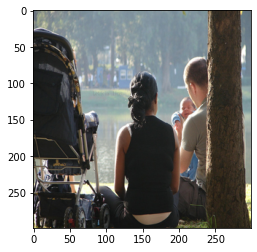

In [ ]:
idx = 17

print("Prediction 4")
image = np.array(enc_train[idx]).reshape(1,2048)
plt.imshow(read_image(train_list[idx]))
print("Captions generated using Greedy-Search")
print("\n")
print(image_decoder(image),"\n")
print("Captions generated using Beam-Search")
print("\n")
print(beam_search(image, beam_index = 1, log=False))
print(beam_search(image, beam_index = 3, log=False))
print(beam_search(image, beam_index = 3, log=False))
print(beam_search(image, beam_index = 4, log=True))

Prediction 5
Captions generated using Greedy-Search


<START> a black dog and a dog are each other on the . <END> 

Captions generated using Beam-Search


<START> a black dog a dog each each other on on . <END>
<START> a black dog a dog each other other on on . <END>
<START> a black dog a dog each other other on . <END>
<START> a black dog a dog each each other on on . <END>


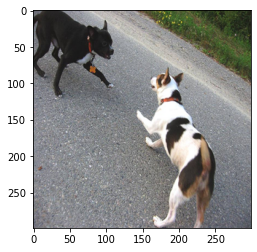

In [ ]:

idx = 1

print("Prediction 5")
image = np.array(enc_train[idx]).reshape(1,2048)
plt.imshow(read_image(train_list[idx]))
print("Captions generated using Greedy-Search")
print("\n")
print(image_decoder(image),"\n")
print("Captions generated using Beam-Search")
print("\n")
print(beam_search(image, beam_index = 3, log=True))
print(beam_search(image, beam_index = 2, log=True))
print(beam_search(image, beam_index = 8, log=False))
print(beam_search(image, beam_index = 3, log=True))


Prediction 6
Captions generated using Greedy-Search


<START> a girl in . <END> 

Captions generated using Beam-Search


<START> a little girl in in in in in . <END>
<START> a little girl in in in in in . <END>
<START> a girl girl in in in in in . <END>
<START> a girl girl in in in in in . <END>


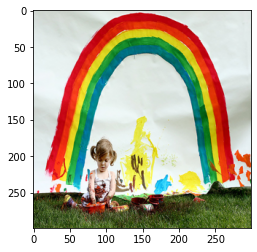

In [ ]:
idx = 2
print("Prediction 6")
image = np.array(enc_train[idx]).reshape(1,2048)
plt.imshow(read_image(train_list[idx]))
print("Captions generated using Greedy-Search")
print("\n")
print(image_decoder(image),"\n")
print("Captions generated using Beam-Search")
print("\n")
print(beam_search(image, beam_index = 3, log=False))
print(beam_search(image, beam_index = 8, log=False))
print(beam_search(image, beam_index = 3, log=True))
print(beam_search(image, beam_index = 1, log=True))



Prediction 7
Captions generated using Greedy-Search


<START> a man with an is wearing a can hat . <END> 

Captions generated using Beam-Search


<START> a man with glasses is is wearing glasses an orange hat . <END>
<START> a man with glasses is is wearing glasses an orange hat . <END>
<START> a man with glasses is is wearing glasses an orange hat . <END>
<START> a man with glasses is is wearing a can hat . <END>


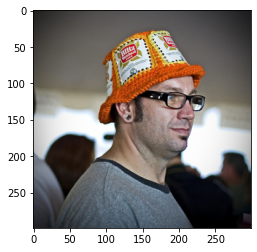

In [ ]:
idx = 4
print("Prediction 7")
image = np.array(enc_train[idx]).reshape(1,2048)
plt.imshow(read_image(train_list[idx]))
print("Captions generated using Greedy-Search")
print("\n")
print(image_decoder(image),"\n")
print("Captions generated using Beam-Search")
print("\n")
print(beam_search(image, beam_index = 3, log=False))
print(beam_search(image, beam_index = 8, log=False))
print(beam_search(image, beam_index = 3, log=True))
print(beam_search(image, beam_index = 2, log=True))


Prediction 8
Captions generated using Greedy-Search


<START> a dog shakes its on shore ball . <END> 

Captions generated using Beam-Search


<START> a dog shakes its on on on shore shore shore ball ball ball ball . <END>
<START> a dog shakes its on on on shore shore shore ball ball ball ball . <END>
<START> a dog shakes its head near on shore shore shore near ball ball . <END>
<START> a dog shakes its head near on shore shore shore near ball ball . <END>


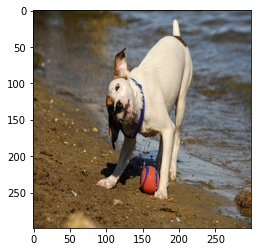

In [ ]:
idx = 7
print("Prediction 8")
image = np.array(enc_train[idx]).reshape(1,2048)
plt.imshow(read_image(train_list[idx]))
print("Captions generated using Greedy-Search")
print("\n")
print(image_decoder(image),"\n")
print("Captions generated using Beam-Search")
print("\n")
print(beam_search(image, beam_index = 1, log=False))
print(beam_search(image, beam_index = 2, log=False))
print(beam_search(image, beam_index = 3, log=False))
print(beam_search(image, beam_index = 4, log=False))


Prediction 9
Captions generated using Greedy-Search


<START> a black dog is running in the grass . <END> 

Captions generated using Beam-Search


<START> a black dog is running in the grass . <END>
<START> a black dog is running in the grass wooden . <END>
<START> a black dog is running in the grass . <END>
<START> a black dog is running in the grass . <END>


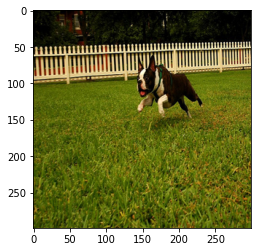

In [ ]:
idx = 6
print("Prediction 9")
image = np.array(enc_train[idx]).reshape(1,2048)
plt.imshow(read_image(train_list[idx]))
print("Captions generated using Greedy-Search")
print("\n")
print(image_decoder(image),"\n")
print("Captions generated using Beam-Search")
print("\n")
print(beam_search(image, beam_index = 1, log=False))
print(beam_search(image, beam_index = 2, log=False))
print(beam_search(image, beam_index = 5, log=False))
print(beam_search(image, beam_index = 4, log=True))


Prediction 10
Captions generated using Greedy-Search


<START> a boy in standing on a street in on a . <END> 

Captions generated using Beam-Search


<START> a boy in standing on a street in in in in in on on on a . <END>
<START> a little boy is standing on the a in in in . <END>
<START> a young boy is standing on the street a in in in in on on a . <END>
<START> a young boy is standing on the street in in in in in on on a . <END>


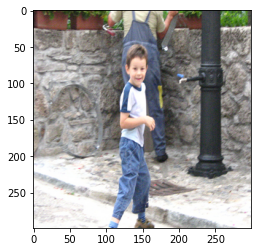

In [ ]:
idx = 8
print("Prediction 10")
image = np.array(enc_train[idx]).reshape(1,2048)
plt.imshow(read_image(train_list[idx]))
print("Captions generated using Greedy-Search")
print("\n")
print(image_decoder(image),"\n")
print("Captions generated using Beam-Search")
print("\n")
print(beam_search(image, beam_index = 1, log=False))
print(beam_search(image, beam_index = 8, log=False))
print(beam_search(image, beam_index = 3, log=False))
print(beam_search(image, beam_index = 4, log=True))



### TESTING Results


Prediction 1
Captions generated using Greedy-Search


<START> a in . <END> 

Captions generated using Beam-Search


<START> a a a in in in . <END>
<START> a a a in in in . <END>
<START> a a a in in in . <END>
<START> a a a in in in . <END>


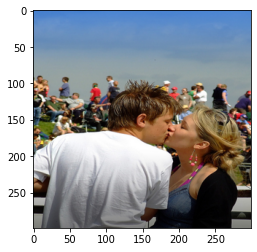

In [ ]:

idx = 1
print("Prediction 1")
image = np.array(enc_test[idx]).reshape(1,2048)
plt.imshow(read_image(test_list[idx]))
print("Captions generated using Greedy-Search")
print("\n")
print(image_decoder(image),"\n")
print("Captions generated using Beam-Search")
print("\n")
print(beam_search(image, beam_index = 1, log=False))
print(beam_search(image, beam_index = 2, log=True))
print(beam_search(image, beam_index = 1, log=False))
print(beam_search(image, beam_index = 4, log=True))

Prediction 2
Captions generated using Greedy-Search


<START> a in . <END> 

Captions generated using Beam-Search


<START> a a a in in in . <END>
<START> a a a in in in . <END>
<START> a a a in in in . <END>
<START> a a a in in in . <END>


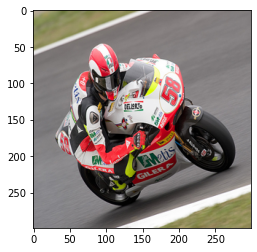

In [ ]:
idx = 2
print("Prediction 2")
image = np.array(enc_test[idx]).reshape(1,2048)
plt.imshow(read_image(test_list[idx]))
print("Captions generated using Greedy-Search")
print("\n")
print(image_decoder(image),"\n")
print("Captions generated using Beam-Search")
print("\n")
print(beam_search(image, beam_index = 1, log=False))
print(beam_search(image, beam_index = 2, log=True))
print(beam_search(image, beam_index = 1, log=False))
print(beam_search(image, beam_index = 4, log=True))

Prediction 3
Captions generated using Greedy-Search


<START> a in . <END> 

Captions generated using Beam-Search


<START> a a in in in in . <END>
<START> a a in in in in . <END>
<START> a a in in in in . <END>
<START> a a in in in in . <END>


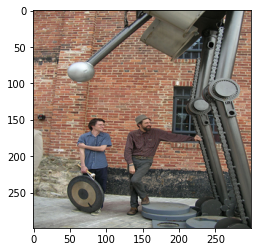

In [ ]:
idx = 3
print("Prediction 3")
image = np.array(enc_test[idx]).reshape(1,2048)
plt.imshow(read_image(test_list[idx]))
print("Captions generated using Greedy-Search")
print("\n")
print(image_decoder(image),"\n")
print("Captions generated using Beam-Search")
print("\n")
print(beam_search(image, beam_index = 1, log=False))
print(beam_search(image, beam_index = 2, log=True))
print(beam_search(image, beam_index = 1, log=False))
print(beam_search(image, beam_index = 4, log=True))

Prediction 4
Captions generated using Greedy-Search


<START> a man in with in . <END> 

Captions generated using Beam-Search


<START> a a man in with with with in in . <END>
<START> a a man in with with with in in . <END>
<START> a a man in with with with in in . <END>
<START> a a man in with with in a . <END>


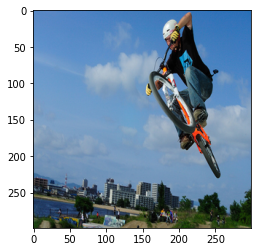

In [ ]:
idx = 4
print("Prediction 4")
image = np.array(enc_test[idx]).reshape(1,2048)
plt.imshow(read_image(test_list[idx]))
print("Captions generated using Greedy-Search")
print("\n")
print(image_decoder(image),"\n")
print("Captions generated using Beam-Search")
print("\n")
print(beam_search(image, beam_index = 1, log=False))
print(beam_search(image, beam_index = 2, log=True))
print(beam_search(image, beam_index = 1, log=False))
print(beam_search(image, beam_index = 4, log=True))

Prediction 5
Captions generated using Greedy-Search


<START> a dog is in . <END> 

Captions generated using Beam-Search


<START> a a dog is in in in . <END>
<START> a a dog is in in in . <END>
<START> a a dog is in in in . <END>
<START> a a dog is in in in . <END>


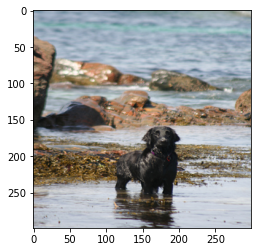

In [ ]:
idx = 5
print("Prediction 5")
image = np.array(enc_test[idx]).reshape(1,2048)
plt.imshow(read_image(test_list[idx]))
print("Captions generated using Greedy-Search")
print("\n")
print(image_decoder(image),"\n")
print("Captions generated using Beam-Search")
print("\n")
print(beam_search(image, beam_index = 1, log=False))
print(beam_search(image, beam_index = 2, log=True))
print(beam_search(image, beam_index = 1, log=False))
print(beam_search(image, beam_index = 4, log=True))

Prediction 7
Captions generated using Greedy-Search


<START> a dog in <END> 

Captions generated using Beam-Search


<START> a a dog in in in in <END>
<START> a a dog in to in in . <END>
<START> a a dog in in in in <END>
<START> a a dog in to in in . <END>


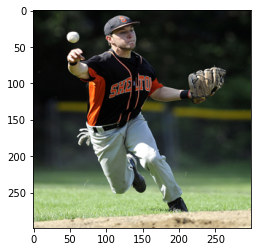

In [ ]:
idx = 7
print("Prediction 7")
image = np.array(enc_test[idx]).reshape(1,2048)
plt.imshow(read_image(test_list[idx]))
print("Captions generated using Greedy-Search")
print("\n")
print(image_decoder(image),"\n")
print("Captions generated using Beam-Search")
print("\n")
print(beam_search(image, beam_index = 1, log=False))
print(beam_search(image, beam_index = 2, log=True))
print(beam_search(image, beam_index = 1, log=False))
print(beam_search(image, beam_index = 4, log=True))

Prediction 8
Captions generated using Greedy-Search


<START> a dog in <END> 

Captions generated using Beam-Search


<START> a a a dog in in in <END>
<START> a a a in in in in <END>
<START> a a a dog in in in <END>
<START> a a a in in in . <END>


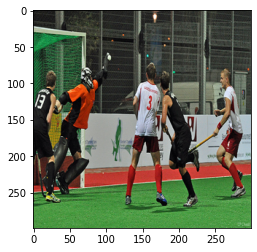

In [ ]:
idx = 8
print("Prediction 8")
image = np.array(enc_test[idx]).reshape(1,2048)
plt.imshow(read_image(test_list[idx]))
print("Captions generated using Greedy-Search")
print("\n")
print(image_decoder(image),"\n")
print("Captions generated using Beam-Search")
print("\n")
print(beam_search(image, beam_index = 1, log=False))
print(beam_search(image, beam_index = 2, log=True))
print(beam_search(image, beam_index = 1, log=False))
print(beam_search(image, beam_index = 4, log=True))

Prediction 9
Captions generated using Greedy-Search


<START> a dog in . <END> 

Captions generated using Beam-Search


<START> a a dog in in in . <END>
<START> a a dog in in in . <END>
<START> a a dog in in in . <END>
<START> a a dog in in in . <END>


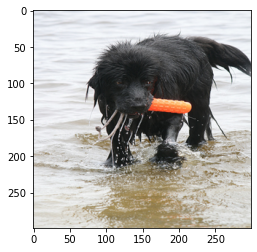

In [ ]:
idx = 9
print("Prediction 9")
image = np.array(enc_test[idx]).reshape(1,2048)
plt.imshow(read_image(test_list[idx]))
print("Captions generated using Greedy-Search")
print("\n")
print(image_decoder(image),"\n")
print("Captions generated using Beam-Search")
print("\n")
print(beam_search(image, beam_index = 1, log=False))
print(beam_search(image, beam_index = 2, log=True))
print(beam_search(image, beam_index = 1, log=False))
print(beam_search(image, beam_index = 4, log=True))

Prediction 10
Captions generated using Greedy-Search


<START> a dog in <END> 

Captions generated using Beam-Search


<START> a a a dog in in in <END>
<START> a a a dog in in . <END>
<START> a a a dog in in in <END>
<START> a a a dog in in . <END>


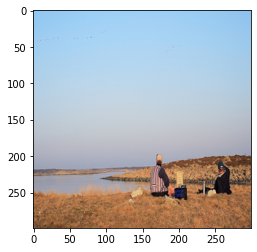

In [ ]:
idx = 817
print("Prediction 10")
image = np.array(enc_test[idx]).reshape(1,2048)
plt.imshow(read_image(test_list[idx]))
print("Captions generated using Greedy-Search")
print("\n")
print(image_decoder(image),"\n")
print("Captions generated using Beam-Search")
print("\n")
print(beam_search(image, beam_index = 1, log=False))
print(beam_search(image, beam_index = 2, log=True))
print(beam_search(image, beam_index = 1, log=False))
print(beam_search(image, beam_index = 4, log=True))